In [21]:
"""
'Get rich quick' scheme, a 5-day prediction of FTSE/TWSE TW50 Index stock prices.

Caveats:

1. We used historical data from the beginning of 2020 (2020/01/02) to the 15th of March 2024
2. We will be predicting the price index
3. We write everything in Python
4. We compare several models and will only submit one result which we think is the best

Hard requirements:

1. The dataset, which is a FTSE/TWSE TW-50 index stock from 2020-01-02 to 2024-03-15
"""

"\n'Get rich quick' scheme, a 5-day prediction of FTSE/TWSE TW50 Index stock prices.\n\nCaveats:\n\n1. We used historical data from the beginning of 2020 (2020/01/02) to the 15th of March 2024\n2. We will be predicting the price index\n3. We write everything in Python\n4. We compare several models and will only submit one result which we think is the best\n\nRequirements:\n"

In [12]:
# ===== Imports =====

import pandas as pd
import matplotlib.pyplot as plt

(18263.0, 19797.0)

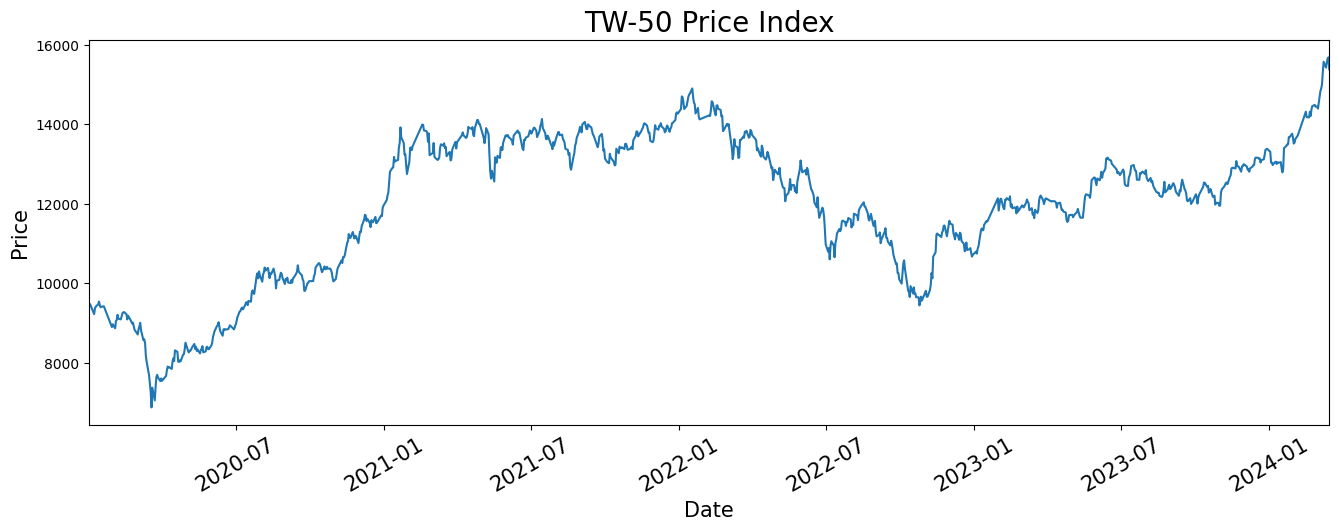

In [20]:
# ===== Data loading and plotting =====

dataset = pd.read_csv('dataset/FTSE TWSE Taiwan 50 Index.csv')

# Since we will be predicting the price index, we will be making a dataframe with the values we'd like to predict
# I am lazy, so we just drop the unused columns instead
df = dataset.drop(columns=['Total Return Index', 'Change', '%Change'])
df['Date'] = pd.to_datetime(df['Date'])

# Now, we just need to plot the dataset
fig = plt.subplots(figsize=(16, 5))
plt.plot(df['Date'], df['Price Index'])
plt.title('TW-50 Price Index', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.xticks(rotation=30, fontsize=15)
plt.xlim(pd.Timestamp('2020-01-02'), pd.Timestamp('2024-03-15'))